In [30]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns
import math

import matplotlib.pyplot as pyplot

In [3]:
data_1 = pd.read_csv("../data/cleaned_data/dataset_1.csv", index_col=0).dropna()
data_2 = pd.read_csv("../data/cleaned_data/dataset_2.csv", index_col=0).dropna()
data_3 = pd.read_csv("../data/cleaned_data/dataset_3.csv", index_col=0).dropna()

In [4]:
len(data_1[data_1["county"] == 37])

91

In [5]:
counter = 0
for county, county_data in data_1.groupby("county"):
    if len(county_data) != 105:
        data_1.drop(data_1[data_1["county"] == county].index, inplace=True, axis=0)
        counter += 1
    
print(counter)

135


In [6]:
data_1.shape

(197085, 12)

In [7]:
data_1.shape[0] / len(data_1["county"].unique())

105.0

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
def separate_data_tf(dataset, observation_period=3, days_in_future=1):
    all_observations = []
    all_targets = []
    
    for county, data_county in dataset.groupby("county"):
        county_targets = pd.concat([data_county["cases"], data_county["deaths"]], axis=1)
        county_observations = data_county.drop(["county", "date"], axis=1)
        
        start_index = observation_period
        end_index = len(county_targets) - days_in_future + 1
        
        for i in range(start_index, end_index):
            indices = range(i-observation_period, i)
            
            observation_series = county_observations.iloc[indices, :]
            all_observations.append(observation_series.values)
            
            target_series = county_targets.iloc[i:i+days_in_future, :].values.flatten('F')
            all_targets.append(target_series)
#         # sanity check
#         print(all_observations[-5:])
#         print(all_targets[-3:])
#         return 

    return np.array(all_observations), np.array(all_targets)

In [27]:
def sequence_data(dataset, observation_period=3, days_in_future=1, train_prop=.8):
    X, y = separate_data_tf(dataset, observation_period, days_in_future)
    dates = len(dataset["date"].unique()) - observation_period
    counties = len(dataset["county"].unique())
    n_feat = X.shape[2]
    
    X_reshaped = X.reshape(dates, observation_period, n_feat*counties)
    y_reshaped = y.reshape(dates, 2*counties)
    
    train_size = int(dates*train_prop)
    X_train, X_test = X_reshaped[:train_size, :], X_reshaped[train_size:, :]
    y_train, y_test = y_reshaped[:train_size, :], y_reshaped[train_size:, :]
    
    return X_train, X_test, y_train, y_test

In [49]:
def make_model(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100, activation="relu"))
    model.add(Dense(100))
    model.add(Dense(y_train.shape[1]))
    model.compile(Adam(learning_rate=.00001), loss='mae')
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    return model

In [34]:
def back_transform_data(predictions, X_test, scaler):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-34-710b43c30fc7>, line 2)

Train on 72 samples, validate on 19 samples
Epoch 1/10
 - 21s - loss: 0.0054 - val_loss: 0.0034
Epoch 2/10
 - 19s - loss: 0.0040 - val_loss: 0.0032
Epoch 3/10
 - 19s - loss: 0.0039 - val_loss: 0.0032
Epoch 4/10
 - 19s - loss: 0.0039 - val_loss: 0.0032
Epoch 5/10
 - 20s - loss: 0.0038 - val_loss: 0.0032
Epoch 6/10
 - 19s - loss: 0.0038 - val_loss: 0.0031
Epoch 7/10
 - 18s - loss: 0.0038 - val_loss: 0.0031
Epoch 8/10
 - 20s - loss: 0.0038 - val_loss: 0.0031
Epoch 9/10
 - 18s - loss: 0.0038 - val_loss: 0.0031
Epoch 10/10
 - 19s - loss: 0.0038 - val_loss: 0.0031


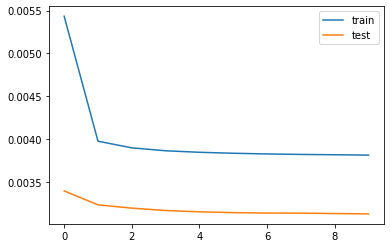

In [50]:
scaler=MinMaxScaler(feature_range=(0,1))
data_transformed = pd.DataFrame(scaler.fit_transform(data_1), columns=data_1.columns)
X_train, X_test, y_train, y_test = sequence_data(data_transformed, 14, 1, .8)
model = make_model(X_train, X_test, y_train, y_test)

In [52]:
yhat = model.predict(X_test)

In [53]:
yhat.shape

(19, 3754)

In [54]:
data_1.head()

,cases,deaths,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density
0,0.0,0.0,0,76,5.0,7.0,17.292916,0.0,-4.0,-0.565632,141.59,92.423365
1,0.0,0.0,1,76,0.0,1.0,-23.000000,0.0,-4.0,-0.662252,104.81,92.423365
2,0.0,0.0,2,76,8.0,0.0,28.290323,0.0,-27.0,5.000000,130.58,92.423365
3,0.0,0.0,3,76,-2.0,0.0,5.185600,0.0,2.0,0.000000,109.61,92.423365
4,0.0,0.0,4,76,-2.0,0.0,8.317308,0.0,2.0,0.000000,119.56,92.423365


In [55]:
data_1.shape

(197085, 12)

In [57]:
last_dates = data_1["date"].unique()[-19]

In [59]:
counties = len(data_1["county"].unique())

In [60]:
counties

1877

In [63]:
yhat.shape[1]/counties

2.0

In [65]:
yhat[0, :2]

array([0.00045985, 0.00024949], dtype=float32)

In [66]:
yhat_reshaped = yhat.reshape(yhat.shape[0] * counties, 2)

In [67]:
yhat_reshaped[0]

array([0.00045985, 0.00024949], dtype=float32)

In [71]:
X = data_1.loc[data_1["date"] >= last_dates]

In [73]:
X.head().reset_index(drop=True)

,cases,deaths,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density
0,84.0,3.0,86,76,0.0,8.0,9.183849,0.0,-27.0,9.0,140.25,92.423365
1,91.0,3.0,87,76,3.0,10.0,24.237643,0.0,-29.0,10.0,151.10,92.423365
2,93.0,3.0,88,76,12.0,14.0,35.709738,0.0,-29.0,10.0,161.95,92.423365
3,103.0,3.0,89,76,1.0,19.0,30.891144,0.0,-30.0,11.0,167.77,92.423365
4,103.0,3.0,90,76,-5.0,12.0,37.260250,0.0,-30.0,11.0,186.77,92.423365


In [78]:
transformed_X = pd.DataFrame(scaler.transform(X.values), columns=X.columns)

In [80]:
transformed_X.drop(["cases", "deaths"], inplace=True, axis=1)

In [82]:
yhat_df = pd.DataFrame(yhat_reshaped, columns=["cases_pred", "deaths_pred"])

In [84]:
transformed_results = pd.concat([yhat_df, transformed_X], axis=1)

In [113]:
results = pd.DataFrame(scaler.inverse_transform(transformed_results))

In [114]:
results.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,35.070983,1.668858,86.0,76.0,0.0,8.0,9.183849,0.0,-27.0,9.0,140.25,92.423365
1,7.392111,0.464621,87.0,76.0,3.0,10.0,24.237643,0.0,-29.0,10.0,151.10,92.423365
2,4.341016,0.182451,88.0,76.0,12.0,14.0,35.709738,0.0,-29.0,10.0,161.95,92.423365
3,6.084019,0.706295,89.0,76.0,1.0,19.0,30.891144,0.0,-30.0,11.0,167.77,92.423365
4,17.793141,1.307234,90.0,76.0,-5.0,12.0,37.260250,0.0,-30.0,11.0,186.77,92.423365


In [115]:
results.columns = transformed_results.columns

In [116]:
results

,cases_pred,deaths_pred,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density
0,35.070983,1.668858,86.0,76.0,0.000000,8.000000,9.183849,0.0,-27.0,9.0,140.25,92.423365
1,7.392111,0.464621,87.0,76.0,3.000000,10.000000,24.237643,0.0,-29.0,10.0,151.10,92.423365
2,4.341016,0.182451,88.0,76.0,12.000000,14.000000,35.709738,0.0,-29.0,10.0,161.95,92.423365
3,6.084019,0.706295,89.0,76.0,1.000000,19.000000,30.891144,0.0,-30.0,11.0,167.77,92.423365
4,17.793141,1.307234,90.0,76.0,-5.000000,12.000000,37.260250,0.0,-30.0,11.0,186.77,92.423365
...,...,...,...,...,...,...,...,...,...,...,...,...
35658,19.355464,0.801028,100.0,1816.0,-15.292083,-0.751484,0.000000,49.0,-61.0,0.0,265.15,9.688359
35659,10.335010,0.150457,101.0,1816.0,17.000000,4.508380,0.000000,17.0,-20.0,0.0,184.38,9.688359
35660,16.790549,-0.690926,102.0,1816.0,17.000000,4.287421,0.000000,16.0,-19.0,0.0,194.96,9.688359
35661,16.696369,0.680555,103.0,1816.0,23.000000,5.350731,0.000000,29.0,-17.0,0.0,228.94,9.688359


In [117]:
results = pd.concat([X[["cases", "deaths"]].reset_index(drop=True), results], axis=1)

In [118]:
results.head()

,cases,deaths,cases_pred,deaths_pred,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density
0,84.0,3.0,35.070983,1.668858,86.0,76.0,0.0,8.0,9.183849,0.0,-27.0,9.0,140.25,92.423365
1,91.0,3.0,7.392111,0.464621,87.0,76.0,3.0,10.0,24.237643,0.0,-29.0,10.0,151.10,92.423365
2,93.0,3.0,4.341016,0.182451,88.0,76.0,12.0,14.0,35.709738,0.0,-29.0,10.0,161.95,92.423365
3,103.0,3.0,6.084019,0.706295,89.0,76.0,1.0,19.0,30.891144,0.0,-30.0,11.0,167.77,92.423365
4,103.0,3.0,17.793141,1.307234,90.0,76.0,-5.0,12.0,37.260250,0.0,-30.0,11.0,186.77,92.423365


In [119]:
results["county"].unique()

array([  76.,   80.,   86., ..., 1757., 1776., 1816.])

In [120]:
results[results["county"] == 1101]

,cases,deaths,cases_pred,deaths_pred,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density
2261,32258.0,1569.0,17.949648,0.797943,86.0,1101.0,-46.0,-18.0,-20.0,-46.0,-45.0,19.0,61.95,2112.464438
2262,33180.0,1613.0,13.073812,0.740039,87.0,1101.0,-46.0,-14.0,-21.0,-45.0,-46.0,20.0,64.64,2112.464438
2263,34428.0,1659.0,15.366837,0.479665,88.0,1101.0,-45.0,-14.0,-16.0,-44.0,-46.0,20.0,67.33,2112.464438
2264,35329.0,1709.0,20.429995,0.649937,89.0,1101.0,-45.0,-14.0,-17.0,-45.0,-46.0,21.0,70.02,2112.464438
2265,36259.0,1755.0,11.602048,0.339621,90.0,1101.0,-46.0,-11.0,-14.0,-44.0,-45.0,21.0,81.59,2112.464438
2266,37303.0,1793.0,14.756242,0.097631,91.0,1101.0,-48.0,-10.0,-22.0,-40.0,-30.0,14.0,78.88,2112.464438
2267,37974.0,1821.0,18.171034,0.776303,92.0,1101.0,-48.0,-15.0,-13.0,-44.0,-30.0,12.0,65.14,2112.464438
2268,38451.0,1839.0,19.005099,0.403109,93.0,1101.0,-45.0,-18.0,-33.0,-49.0,-44.0,19.0,67.71,2112.464438
2269,39573.0,1913.0,20.355140,-0.300566,94.0,1101.0,-42.0,-13.0,-13.0,-44.0,-44.0,19.0,74.04,2112.464438
2270,40857.0,1970.0,13.323237,0.126044,95.0,1101.0,-42.0,-11.0,-10.0,-43.0,-44.0,19.0,75.83,2112.464438
